In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Now we make the function "f" that we wish to approximate with the RBF gaussian kernel
# "f" :  is 2 dimensional!!

N = 250                                # No. of sample points along x axis
M = 250                                # No. of sample points along y axis

eps = 1.5                              # The epsilon parameter of the phi() kernel function

def polynomial(x, y):
    z = 0.6*np.sin(0.3*x + np.pi/7) + 0.95*np.cos(0.8*y) + 0.85*np.sin(0.085*x + 4*np.pi/13) + np.sin(0.38*y + 2*np.pi/3)
    return z

# Creating the sample points and retaining them in shape NxM
x, y = np.meshgrid(np.linspace(-15, 15, N), np.linspace(-15, 15, M))

# Initializing the NxM matrix for f - the function which will be approximated with the rbf kernels later!
f = polynomial(x, y)
print('shape of f: ', f.shape)

shape of f:  (250, 250)


<IPython.core.display.Javascript object>


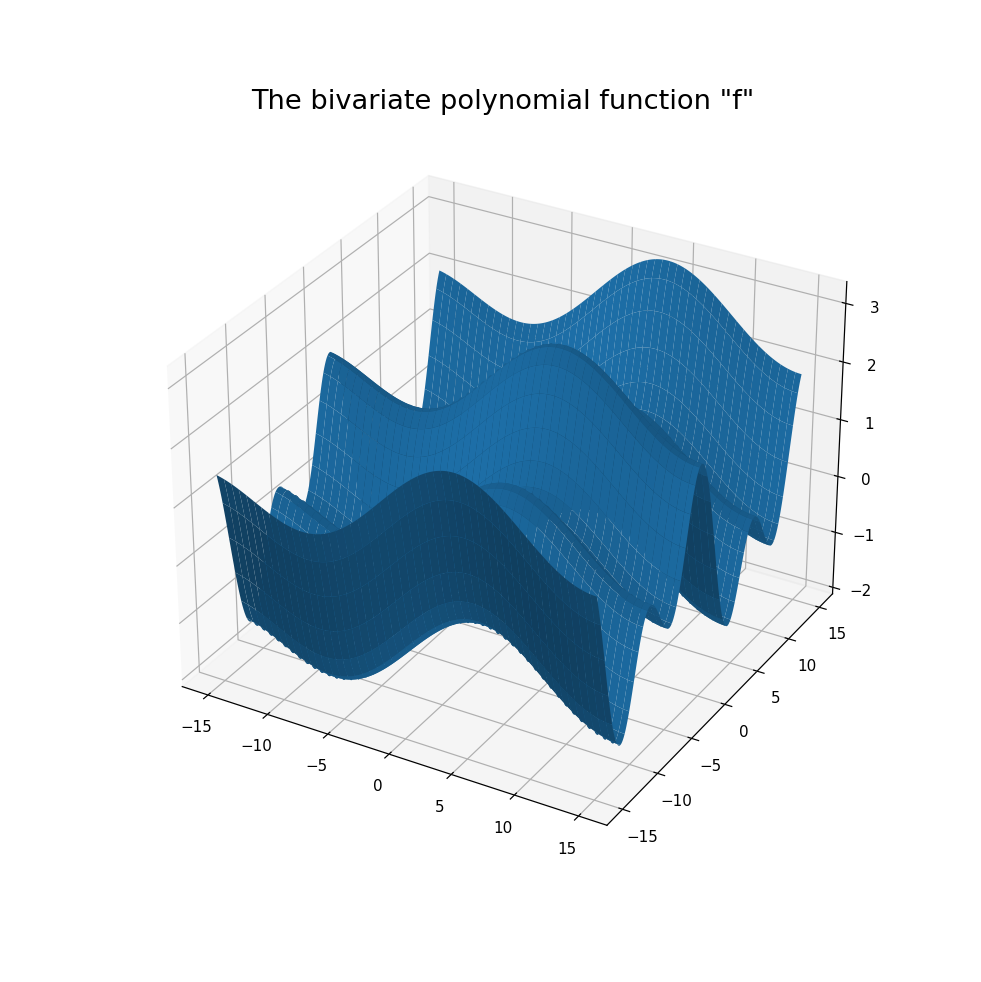

In [3]:
# Plotting the function "f" that we're going to be approximating

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
fig.set_figheight(9)
fig.set_figwidth(9)
ax.plot_surface(x, y, f)
ax.set_title('The bivariate polynomial function "f"', fontsize=18)
ax.grid(True)
plt.show()

In [4]:
# Sample some "n" of the N points that make up the function "f"

# Edit these values to change the number of points based on which we perform the approximation!!
numSamp_n = 15             # along the rows
numSamp_m = 15             # along the cols
print('num samples along the two axes: ', numSamp_n, ' x ', numSamp_m)


n = N // numSamp_n        # closest multiple of numSamp lesser than N 
m = M // numSamp_m        # closest multiple of numSamp lesser than M


# Create the row vectors of the sample indices for the x and y values
sampInd_x = np.linspace(0, numSamp_n*n-1, numSamp_n).astype(int)      # sample indices at intervals of n
sampInd_y = np.linspace(0, numSamp_m*m-1, numSamp_m).astype(int)      # sample indices at intervals of n

sx, sy = np.meshgrid(sampInd_x, sampInd_y)
sx = sx.flatten()
sy = sy.flatten()

num samples along the two axes:  15  x  15


In [5]:
fSamples = f[list(sx), list(sy)].reshape(numSamp_n, numSamp_m)
xSamples = x[sx, sy].reshape(numSamp_n, numSamp_m)
ySamples = y[sx, sy].reshape(numSamp_n, numSamp_m)

print('Shape of fSamples: ', fSamples.shape)

assert (fSamples.shape[0] == xSamples.shape[0]) and (xSamples.shape[0] == ySamples.shape[0]), print(':(')
assert (fSamples.shape[1] == xSamples.shape[1]) and (xSamples.shape[1] == ySamples.shape[1]), print(':(')

Shape of fSamples:  (15, 15)


<IPython.core.display.Javascript object>


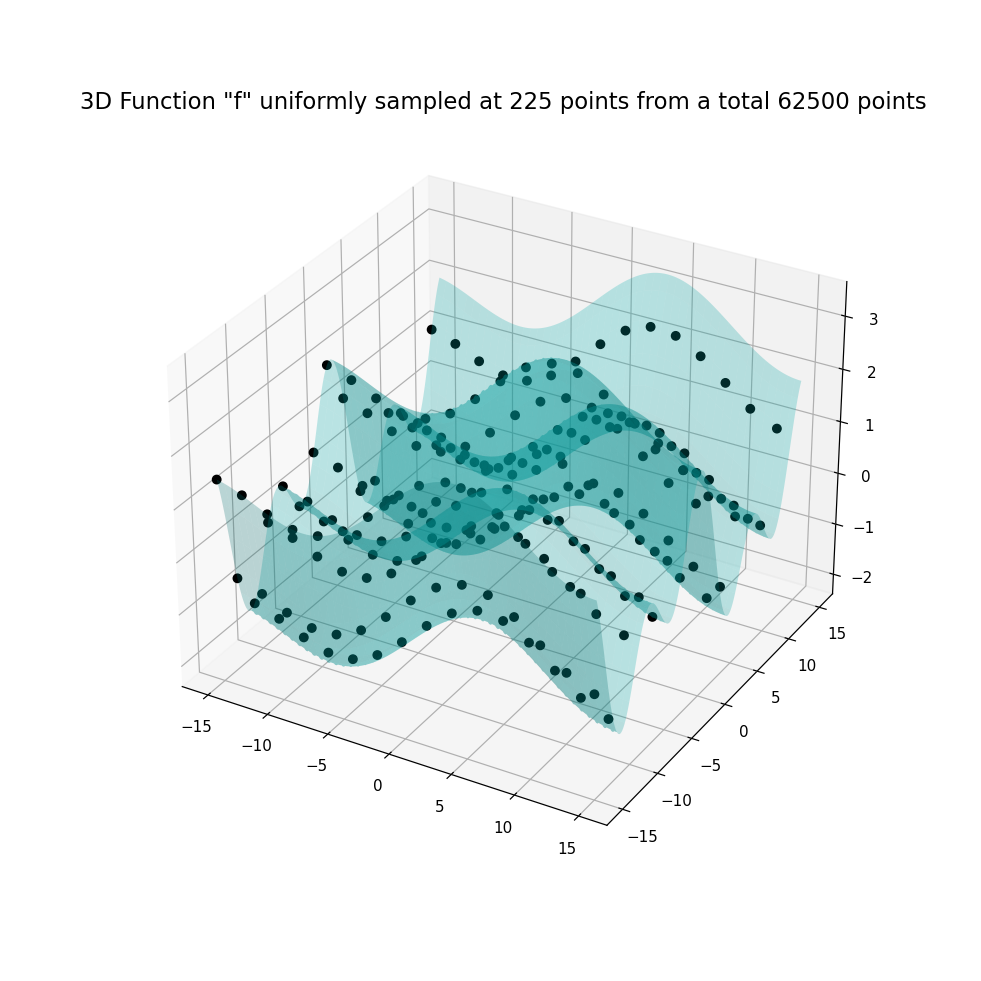

In [6]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
fig.set_figheight(9)
fig.set_figwidth(9)
ax.plot_surface(x, y, f, color='c', alpha=0.25, label='function surface')
ax.scatter(xSamples, ySamples, fSamples, s=np.ones_like(fSamples)*30, color='k', marker='o', alpha=1, label='sample point')
ax.set_title('3D Function "f" uniformly sampled at {} points from a total {} points'.format(numSamp_n*numSamp_m, N*M), fontsize=15)
ax.grid(True)
plt.show()

In [7]:
# This cell defines the kernel function phi which is a scaled gaussian function with one free parameter
# "epsilon". It takes as input any single "r" or a vector of "r" scalars in the form of a vector

def phi_biVar(eps, r1, r2):
    
    phi_r1_r2 = np.exp(-(eps**2)*(r1**2 + r2**2 ))
    
    return phi_r1_r2

In [8]:
# The makePhiMatrix takes in an array of xPts, the "phi" kernel function from the previous cell and its epsilon
# parameter and returns the RBF basis function matrix "B" as defined in the Wiki page:
# https://en.wikipedia.org/wiki/Radial_basis_function_interpolation

def makePhiMatrix_biVar(x1Pts, x2Pts, kernel, eps):
    
    x1Pts = x1Pts.flatten()
    x2Pts = x2Pts.flatten()
    print('\nlen x1: ', len(x1Pts))
    print('len x2: ', len(x2Pts))
    
    
    n = len(x1Pts)                # how many pts there are along the x direction
    m = len(x2Pts)                # how many pts there are along the y direction
    print('n = ', n, '    m = ', m)
    
    
    r, c = np.meshgrid(np.arange(n), np.arange(m))
    r    = r.flatten()
    c    = c.flatten()
    print('\nr len: ', len(r))
    print('c len: ', len(c))
    
    
    print('len(x1Pts[r]-x1Pts[c])', len(x1Pts[r]-x1Pts[c]))
    print('len(x2Pts[r]-x2Pts[c])', len(x2Pts[r]-x2Pts[c]))
    B = phi_biVar(eps, x1Pts[r]-x1Pts[c], x2Pts[r]-x2Pts[c])
    
    print('shape of B: ', B.shape)
    
    B = np.expand_dims(B, axis=1).reshape(n, m)
    
    print('New shape of B [nxm]: ', B.shape)
    
    return B

<IPython.core.display.Javascript object>


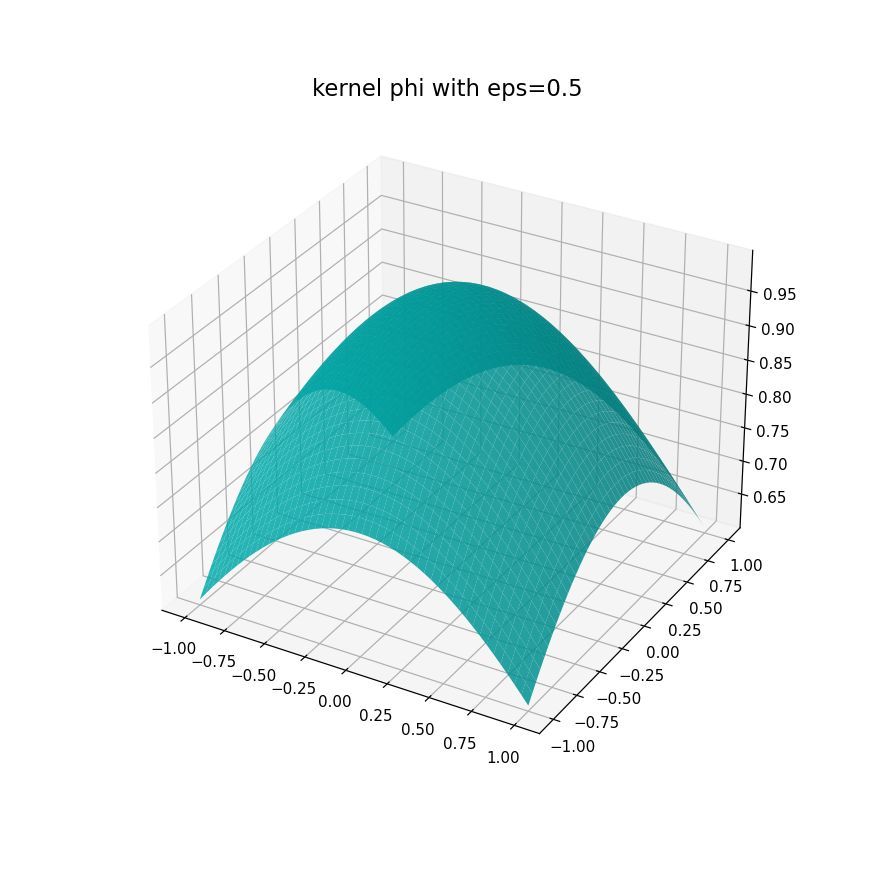

In [9]:
# Testing out whether phi_biVar works by plotting it over a random grid of points

r1, r2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))

eps = 0.5

phi = phi_biVar(eps, r1, r2)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
fig.set_figheight(8)
fig.set_figwidth(8)
ax.plot_surface(r1, r2, phi, color='c', alpha=0.85)
ax.set_title('kernel phi with eps={}'.format(eps), fontsize=15)
ax.grid(True)
plt.show()

In [10]:
 # Setting up the problem to solve the weights:

## x1Pts = xSamples                   # the numSamp number of theta (x) points are stored in xPts 
## x2Pts = ySamples                   # the numSamp number of theta (x) points are stored in xPts 

B = makePhiMatrix_biVar(x1Pts=xSamples, x2Pts=ySamples, kernel=phi, eps=eps)    # returns a [(N//n+1) x (N//n+1)] matrix

wts = np.linalg.inv(B) @ fSamples.reshape(-1,1)     # w = B_inv[n x m] @ f[n x m]

print('\nshape of weights vector: ', wts.shape)


len x1:  225
len x2:  225
n =  225     m =  225

r len:  50625
c len:  50625
len(x1Pts[r]-x1Pts[c]) 50625
len(x2Pts[r]-x2Pts[c]) 50625
shape of B:  (50625,)
New shape of B [nxm]:  (225, 225)

shape of weights vector:  (225, 1)


In [11]:
# Approximating the function using the weighted sum of the kernels

f = f.reshape(-1,1)
fApprx = np.zeros_like(f)                       # initializing the approximated function with N zeros

print('shape of x: ', x.shape)
print('shape of y: ', y.shape)

x = x.reshape(-1)
y = y.reshape(-1)

print('\nnew shape of x: ', x.shape)
print('new shape of y: ', y.shape)

print('\nxSamples shape: ', xSamples.shape)
print('\nySamples shape: ', ySamples.shape)

shape of x:  (250, 250)
shape of y:  (250, 250)

new shape of x:  (62500,)
new shape of y:  (62500,)

xSamples shape:  (15, 15)

ySamples shape:  (15, 15)


fApprx initialized shape:  (62500, 1)


<IPython.core.display.Javascript object>


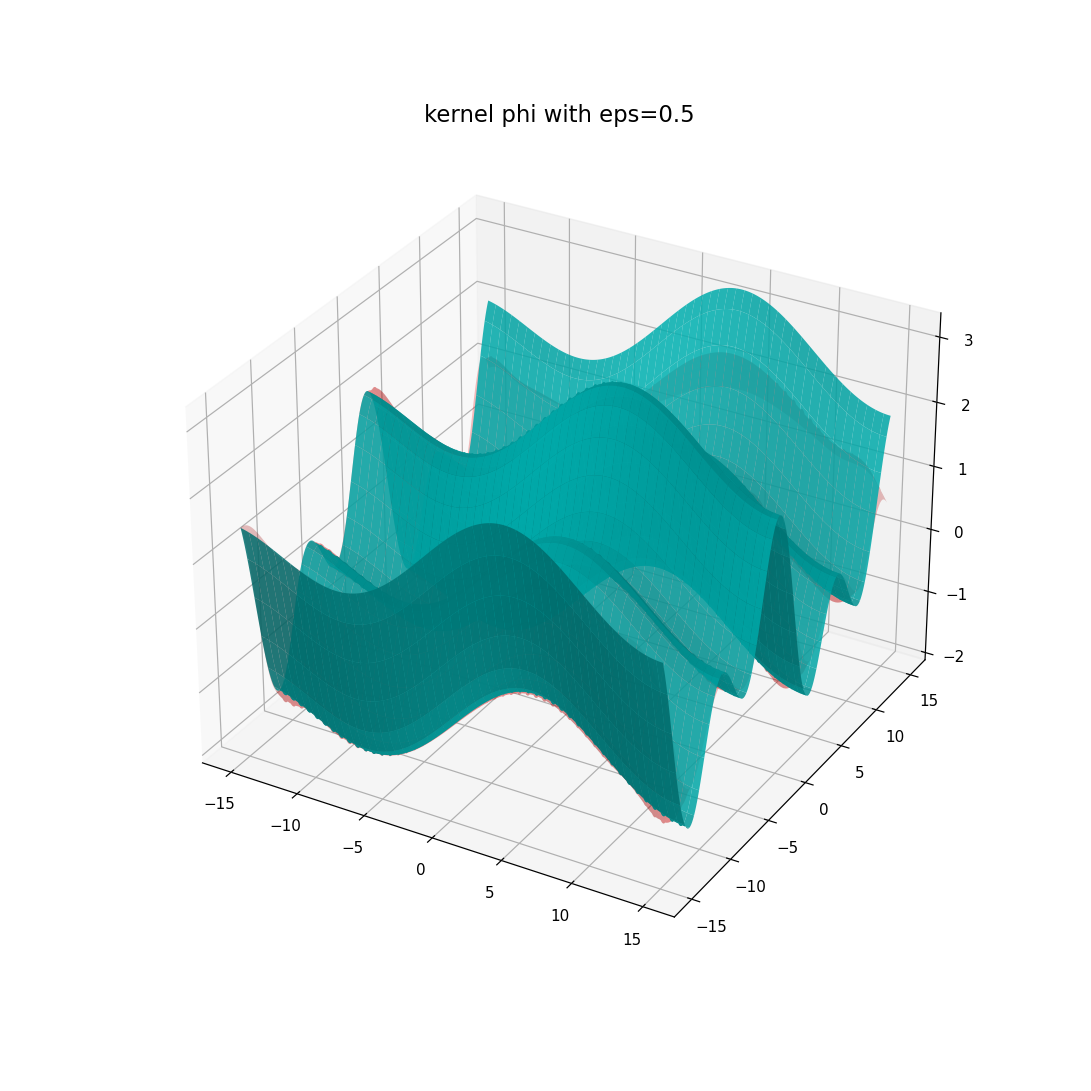

In [12]:
i = 0

print('fApprx initialized shape: ', fApprx.shape)

for xS, yS in zip(x, y):
    phi_x1_x2 = phi_biVar(eps, xS-xSamples, yS-ySamples)
    # print('phi_r_x shape: ', phi_x1_x2.shape)   # 15x15
    fApprx[i,0] = phi_x1_x2.reshape(-1,1).T @ wts                  # 1x21 @ 21x1 : phi(x-xSampled) @ weights
    i += 1

fApprx = fApprx.reshape(N, M)
f      = f.reshape(N,M)
x      = x.reshape(N,M)
y      = y.reshape(N,M)
    
# Plotting the Approximated function
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
fig.set_figheight(10)
fig.set_figwidth(10)
ax.plot_surface(x.reshape(N,M), y.reshape(N,M), f.reshape(N,M), color='c', alpha=0.85)
ax.plot_surface(x.reshape(N,M), y.reshape(N,M), fApprx        , color='r', alpha=0.25)
ax.set_title('kernel phi with eps={}'.format(eps), fontsize=15)
ax.grid(True)
plt.show()

<IPython.core.display.Javascript object>


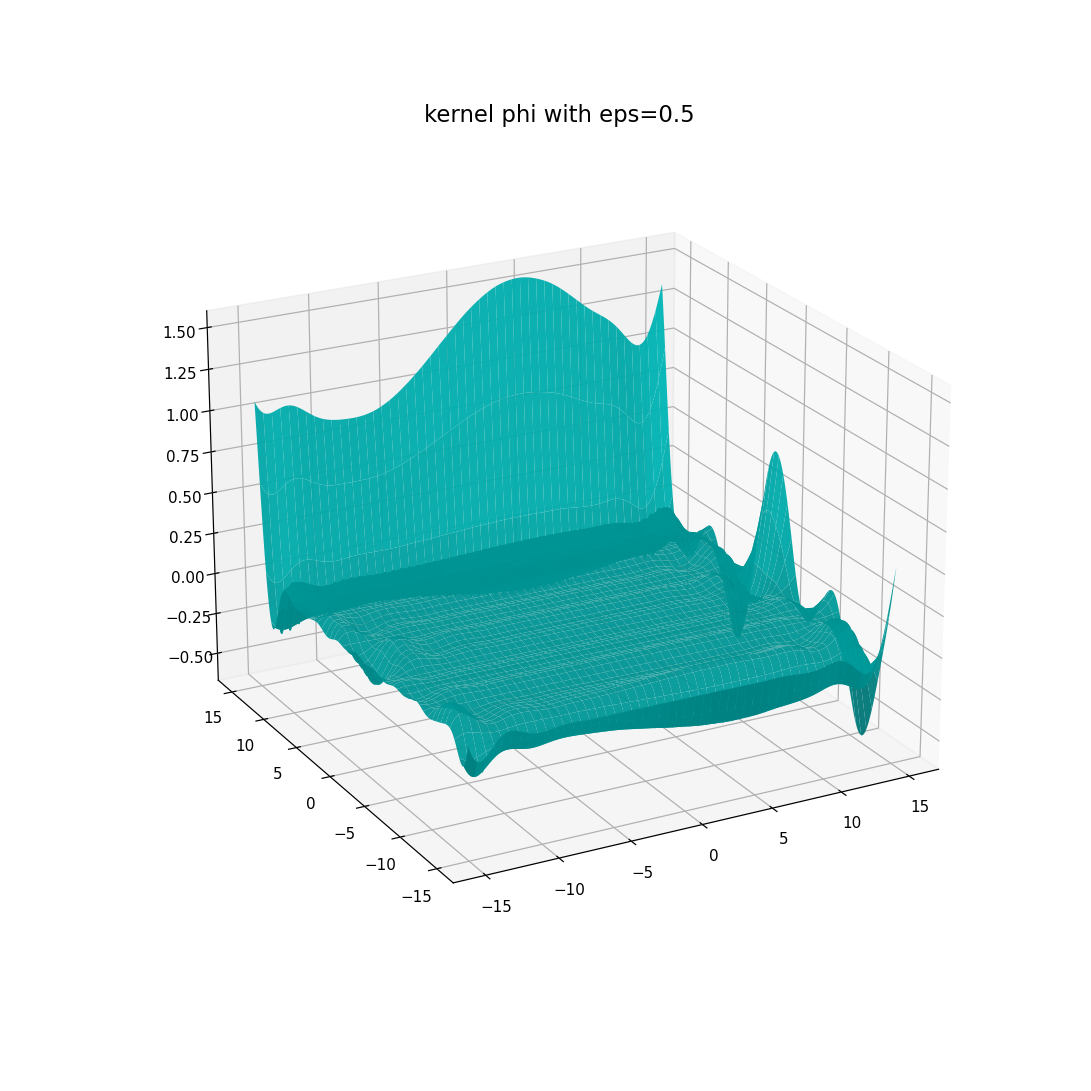

In [13]:
# Plotting the error

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
fig.set_figheight(10)
fig.set_figwidth(10)
ax.plot_surface(x, y, f-fApprx, color='c', alpha=0.95)
ax.set_title('kernel phi with eps={}'.format(eps), fontsize=15)
ax.grid(True)
plt.show()